In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datajoint as dj
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_style('ticks', rc={'image.cmap': 'bwr'})

import os
import sys
import inspect

p = !pwd
p = os.path.dirname(os.path.dirname(p[0]))
if p not in sys.path:
    sys.path.append(p)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from cnn_sys_ident.mesonet.data import MultiDataset
from cnn_sys_ident.mesonet.parameters import Core, Readout, Model, RegPath, Fit
from cnn_sys_ident.mesonet import MODELS
from cnn_sys_ident.mesonet.controls import FitTrialSubset

Connecting aecker@52.202.15.166:3306


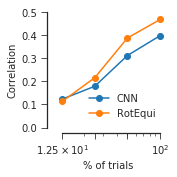

In [3]:
plt.figure(figsize=(2.5, 2.5))

frac_trials = np.array([0.125, 0.25, 0.5, 1])
for model in [MODELS['CNNSparse'], MODELS['HermiteSparse']]:
    test_corr = []
    for t in frac_trials + 0.01:
        rel = (FitTrialSubset() * model & 'frac_trials < {}'.format(t))
        test_corr.append(rel.fetch('test_corr', order_by='val_loss', limit=1)[0])

    plt.semilogx(100 * frac_trials, test_corr, 'o-')
    
plt.legend(['CNN', 'RotEqui'])
plt.xlabel('% of trials')
plt.ylabel('Correlation')
plt.tight_layout()
plt.xlim([10, 110])
plt.ylim([0, 0.5])
plt.xticks(frac_trials * 100)
sns.despine(trim=True, offset=5)
plt.savefig('figures/frac_trials.eps', format='eps')

# Split the data in half to compute MEIs

In [4]:
from cnn_sys_ident.mesonet.controls import FitDataSplit, MEIParams, MEIGroup, MEI
from cnn_sys_ident.architectures.training import Trainer
from cnn_sys_ident.mesonet.data import MultiDataset
from cnn_sys_ident.mesonet.parameters import Fit
from cnn_sys_ident.mesonet.vis import MEI as OriginalMEI
from cnn_sys_ident.mesonet import MODELS

### Original MEI, 50/50 and gradient in one plot

In [5]:
data_key = {'data_hash': 'cfcd208495d565ef66e7dff9f98764da'}
dataset = MultiDataset() & data_key
num_filters = 16
model_rel = MODELS['HermiteSparse'] * dataset \
    & 'positive_feature_weights=False AND shared_biases=False' \
    & {'num_filters_2': num_filters}
model_key = (Fit() * model_rel).fetch(dj.key, order_by='val_loss', limit=1)[0]
num_rotations = (model_rel & model_key).fetch1('num_rotations')

In [6]:
from cnn_sys_ident.utils.mei import GradientRF

model = Fit().get_model(model_key)
tfs = model.base.tf_session
graph = tfs.graph
checkpoint_file = os.path.join(tfs.log_dir, 'model.ckpt')
input_shape = [model.base.data.input_shape[1], model.base.data.input_shape[2]]
gradRF = GradientRF(graph, checkpoint_file, input_shape)

INFO:tensorflow:Restoring parameters from /gpfs01/bethge/home/aecker/home/lab/projects/microns/cnn-sys-ident-iclr/checkpoints/aecker_mesonet_data/647bb1d1bd02979996e492b5422eb95f/model.ckpt


In [7]:
model = Fit().load_model(model_key)
masks = model.base.evaluate(model.readout.masks)

INFO:tensorflow:Restoring parameters from /gpfs01/bethge/home/aecker/home/lab/projects/microns/cnn-sys-ident-iclr/checkpoints/aecker_mesonet_data/647bb1d1bd02979996e492b5422eb95f/model.ckpt


In [8]:
trainer = Trainer(model.base, model)
# r = trainer.compute_val_corr()
r = trainer.compute_test_corr(average=False)
print(r.mean())

0.4705570979699102


In [10]:
def crop_and_plot_rf(img, mask, k, ax):
    img = np.pad(img, k, 'constant')
    mask = np.pad(masks[unit_id], k, 'constant')
    rf_idx = mask.argmax()
    rf_i, rf_j = rf_idx // n_x, rf_idx % n_x
    img  = img[rf_i-k:rf_i+k,rf_j-k:rf_j+k]
    m = np.abs(img).max() + 1e-3
    ax.imshow(img, vmin=-m, vmax=m)
    ax.axis('off')    

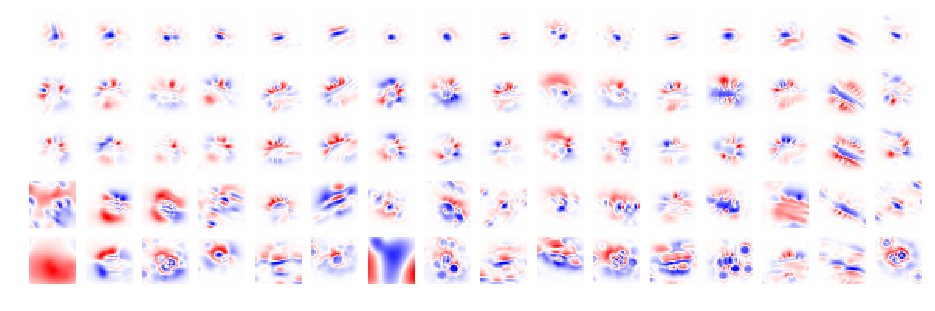

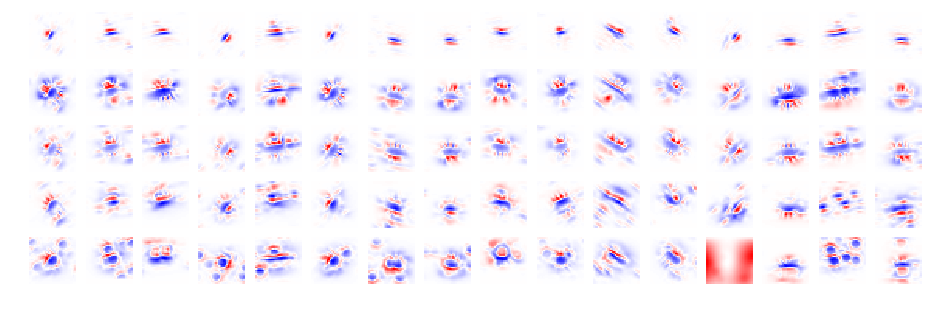

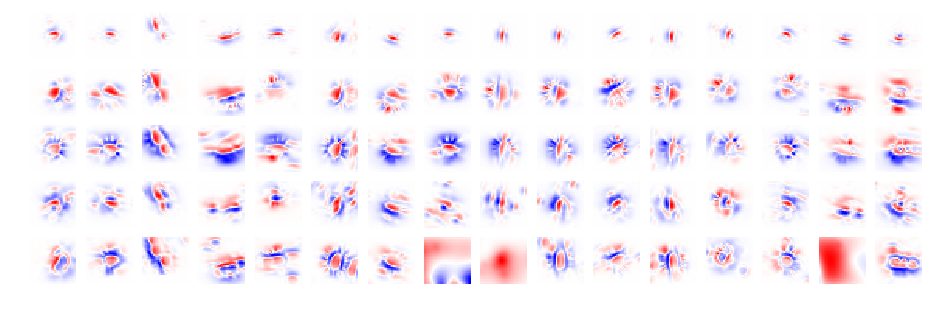

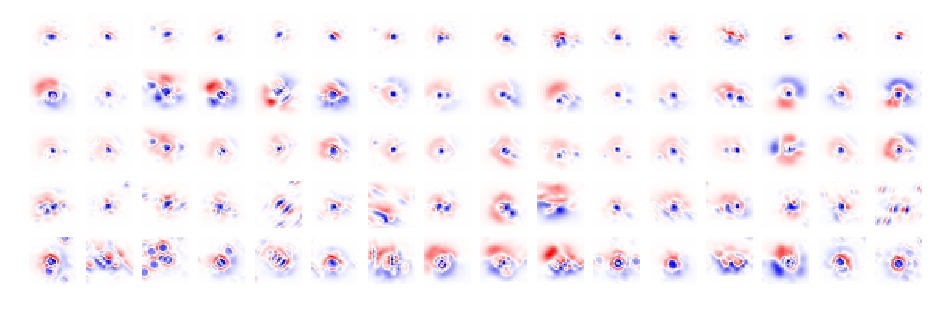

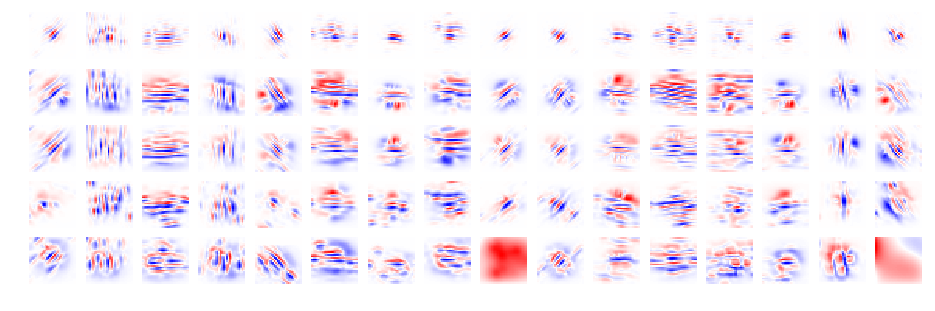

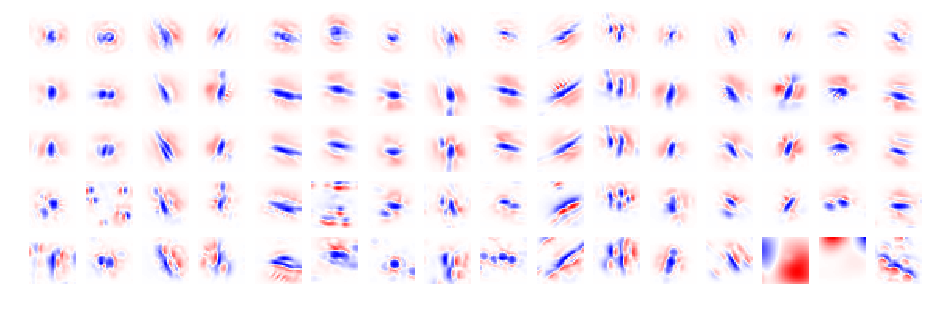

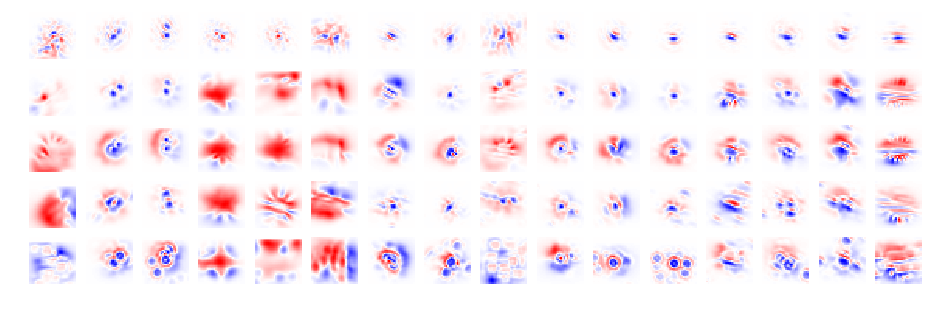

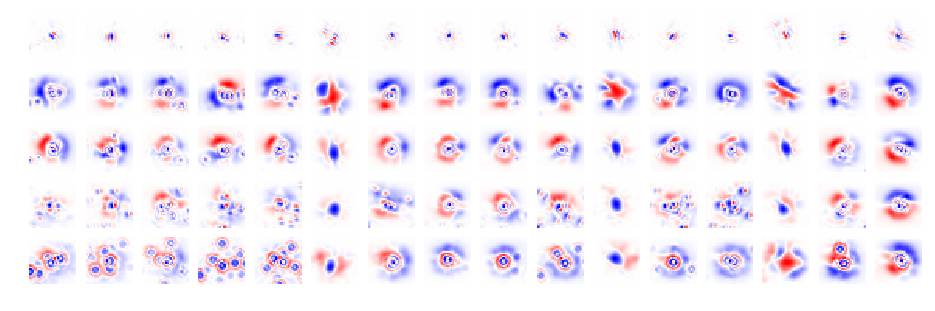

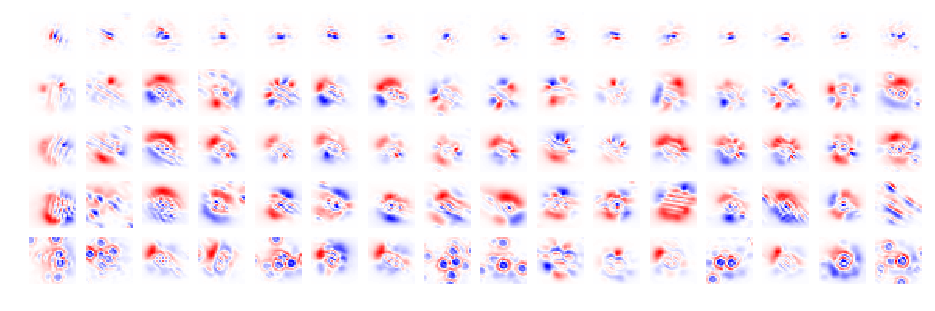

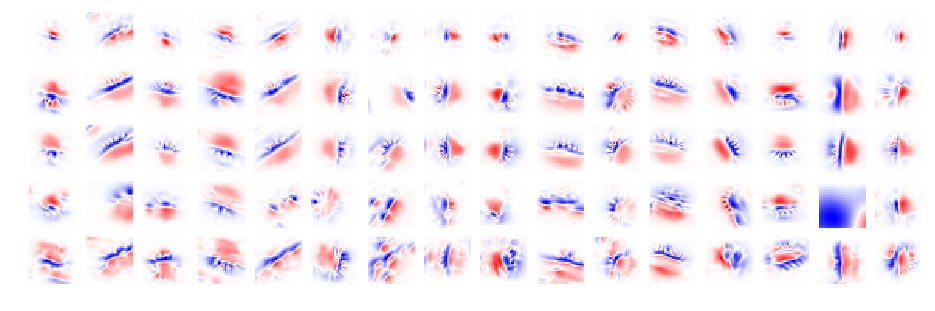

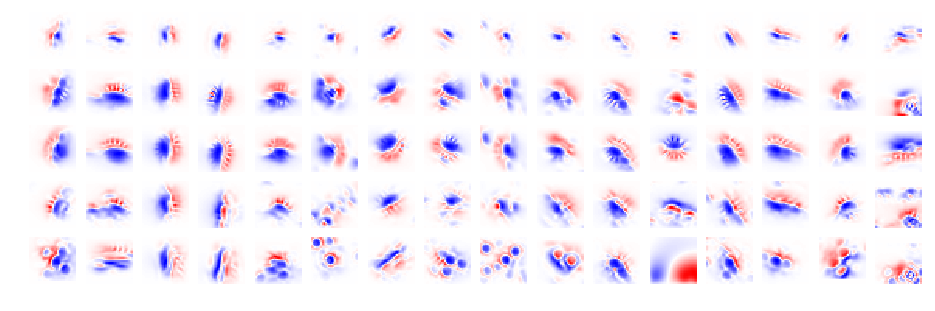

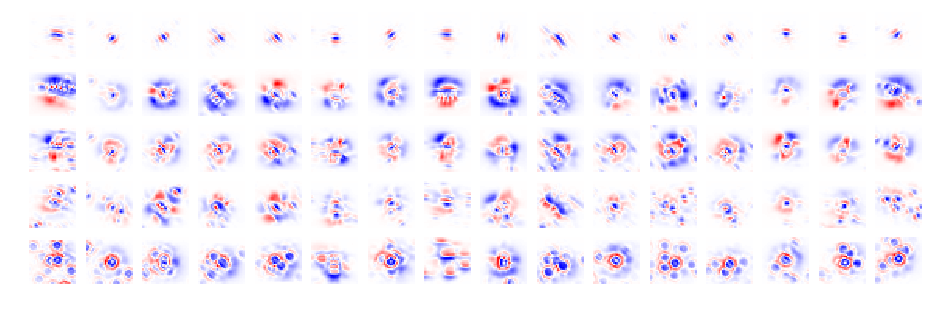

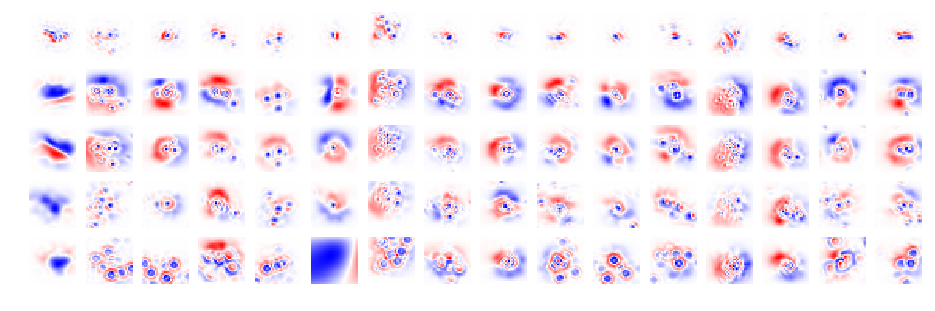

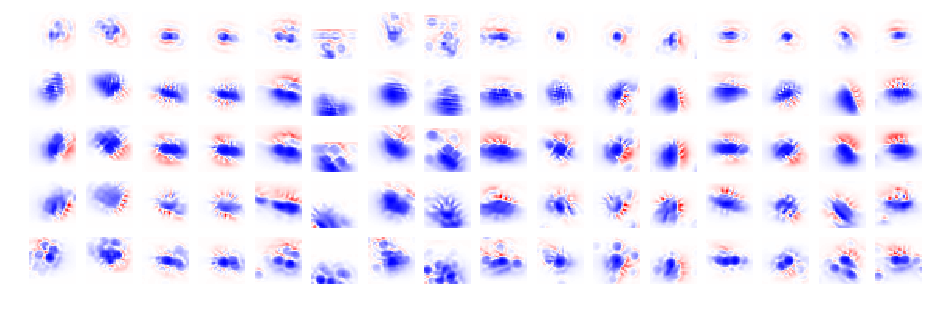

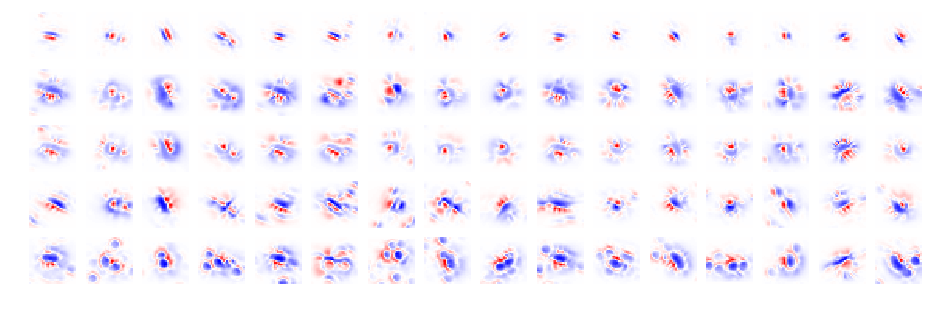

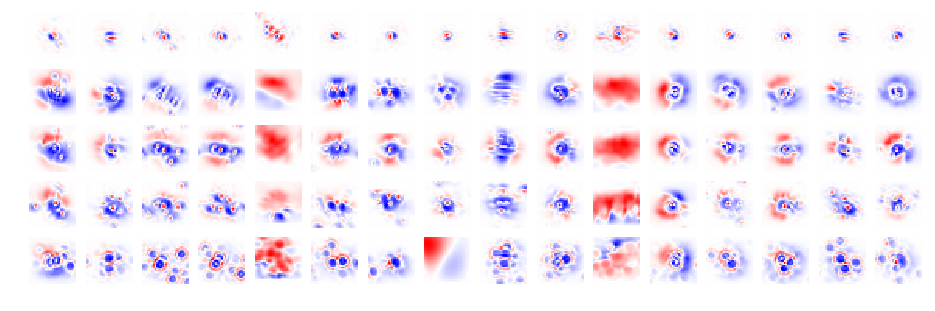

In [31]:
unit_ids = np.load('figures/unit_ids.npy')
k = 15   # x2
n_x = masks.shape[2] + 2*k
n = [5, 16]
alternative_model_key = model_key.copy()
alternative_model_key['reg_seed'] = 1954773306
for i, unit_ids_i in enumerate(unit_ids):
    fig, axes = plt.subplots(n[0], n[1], figsize=(n[1], n[0]))
    for j, unit_id in enumerate(unit_ids_i):
        # Gradient RF
        img = gradRF.gradient(unit_id)
        crop_and_plot_rf(img, masks[unit_id], k, axes[0,j])
        
        # Full MEI alternative model
        key = dict(unit_id=unit_id, param_id=1)
        img = (OriginalMEI() & key & alternative_model_key).fetch1('max_image')
        crop_and_plot_rf(img, masks[unit_id], k, axes[1,j])
        
        # Full MEI
        key = dict(unit_id=unit_id, param_id=1)
        img = (OriginalMEI() & key & model_key).fetch1('max_image')
        crop_and_plot_rf(img, masks[unit_id], k, axes[2,j])
        
        # 50/50 data splits
        for split_num in range(2):
            key = dict(unit_id=unit_id,
                       num_splits=2,
                       split_num=split_num,
                       param_id=1)
            rel = MEI() & key
            if len(rel):# and r[unit_id] > 0.55:
                img = rel.fetch1('max_image')
                crop_and_plot_rf(img, masks[unit_id], k, axes[3+split_num,j])

    fig.savefig('figures/meis_alt_grad_split_{:d}.eps'.format(i+1), format='eps')